In [ ]:
import warnings
warnings.filterwarnings("ignore")


In [ ]:
# CELL 1: GENESIS & CORE DNA
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import shutil
from datetime import datetime

# --- QUANTUM SEEDING ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"⚡ Hardware: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

# --- CONSTANTS ---
CHANNELS = 16
GRID_SIZE = 72
FIRE_RATE = 0.5
POOL_SIZE = 1024
CRYO_PATH = "nanoscale_agi_ultimate"
os.makedirs(CRYO_PATH, exist_ok=True)

print(f"🌌 Universe Created | {CHANNELS}D DNA | {GRID_SIZE}x{GRID_SIZE} Grid")

# --- DNA ARCHITECTURE ---
class NeuroGenome(nn.Module):
    def __init__(self, channels=16, hidden_dim=128):
        super().__init__()
        self.channels = channels
        self.perceive = nn.Conv2d(channels, hidden_dim, kernel_size=3, padding=1, bias=True)
        self.think = nn.Conv2d(hidden_dim, channels, kernel_size=1, bias=True)

        with torch.no_grad():
            self.think.weight.data.zero_()
            self.think.bias.data.zero_()

    def forward(self, x):
        sensory_data = self.perceive(x)
        thought = torch.relu(sensory_data)
        update = self.think(thought)

        b, c, h, w = x.shape
        stochastic_mask = (torch.rand(b, 1, h, w, device=x.device) > 0.5).float()
        return x + update * stochastic_mask

organism_dna = NeuroGenome(CHANNELS).to(device)
param_count = sum(p.numel() for p in organism_dna.parameters())
print(f"🧬 DNA Created: {param_count:,} parameters")

# --- CRYOSTASIS ---
class CryoChamber:
    def __init__(self, save_dir=CRYO_PATH):
        self.save_dir = save_dir

    def freeze(self, dna, body_state, optimizer, epoch, loss_history):
        filename = os.path.join(self.save_dir, f"agi_checkpoint_epoch_{epoch}.pth")
        capsule = {
            'dna_state': dna.state_dict(),
            'body_state': body_state.detach().cpu(),
            'optimizer_state': optimizer.state_dict(),
            'epoch': epoch,
            'loss_history': loss_history,
            'random_rng': torch.get_rng_state()
        }
        torch.save(capsule, filename)
        print(f"❄️ Frozen at Epoch {epoch}")
        return filename

    def resurrect(self, dna, optimizer, filepath):
        if not os.path.exists(filepath):
            print("⚠️ No checkpoint found. Starting from Genesis.")
            return None, 0, []

        print(f"⚡ Resurrecting from {filepath}...")
        capsule = torch.load(filepath, map_location=device)
        dna.load_state_dict(capsule['dna_state'])
        optimizer.load_state_dict(capsule['optimizer_state'])
        torch.set_rng_state(capsule['random_rng'].cpu())
        body_state = capsule['body_state'].to(device)
        print(f"✅ Restored at Epoch {capsule['epoch']}")
        return body_state, capsule['epoch'], capsule['loss_history']

cryo = CryoChamber()
print("🧊 CryoChamber Ready")

# --- ENVIRONMENT PHYSICS ---
def generate_target_pattern(size=GRID_SIZE):
    x = np.linspace(-1, 1, size)
    y = np.linspace(-1, 1, size)
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)
    pattern = np.exp(-10 * (R - 0.5)**2) + np.exp(-20 * R**2)
    target = torch.from_numpy(pattern).float().to(device)
    target = target.unsqueeze(0).repeat(CHANNELS, 1, 1)
    return target[:4, :, :]

TARGET = generate_target_pattern()
TARGET_BATCH = TARGET.unsqueeze(0).repeat(POOL_SIZE, 1, 1, 1)

def make_seed(pool_size=POOL_SIZE, channels=CHANNELS, size=GRID_SIZE):
    seed = torch.zeros(pool_size, channels, size, size, device=device)
    mid = size // 2
    seed[:, 3:, mid, mid] = 1.0
    seed[:, :, mid, mid] = 1.0
    return seed

def damage_organism(x):
    b, c, h, w = x.shape
    mask = torch.ones(b, 1, h, w, device=x.device)
    for i in range(b):
        center_x = torch.randint(0, w, (1,)).item()
        center_y = torch.randint(0, h, (1,)).item()
        radius = torch.randint(5, 15, (1,)).item()
        Y, X = torch.meshgrid(torch.arange(h, device=device), torch.arange(w, device=device), indexing='ij')
        dist = torch.sqrt((X - center_x)**2 + (Y - center_y)**2)
        mask[i, :, :, :] = (dist > radius).float()
    return x * mask

def inject_emotions(x, adrenaline, serotonin, cortisol):
    b, c, h, w = x.shape
    l_adr = torch.full((b, 1, h, w), float(adrenaline), device=device)
    l_ser = torch.full((b, 1, h, w), float(serotonin), device=device)
    l_cor = torch.full((b, 1, h, w), float(cortisol), device=device)
    body = x[:, :13, :, :]
    return torch.cat([body, l_adr, l_ser, l_cor], dim=1)

def apply_scent_gradient(x, target_center_x, target_center_y):
    b, c, h, w = x.shape
    Y, X = torch.meshgrid(torch.arange(h, device=device), torch.arange(w, device=device), indexing='ij')
    dist_x = (X - target_center_x) / (w / 2)
    dist_y = (Y - target_center_y) / (h / 2)
    scent = 1.0 - torch.sqrt(dist_x**2 + dist_y**2)
    scent = torch.clamp(scent, -1.0, 1.0)
    scent_layer = scent.unsqueeze(0).unsqueeze(0).repeat(b, 1, 1, 1)
    x_body = x[:, :-1, :, :]
    return torch.cat([x_body, scent_layer], dim=1)

def get_complex_target(mode_vector, step):
    adr, ser, cor = mode_vector
    Y, X = torch.meshgrid(torch.arange(GRID_SIZE, device=device), torch.arange(GRID_SIZE, device=device), indexing='ij')
    angle = step * (0.05 + (adr * 0.2))
    radius = 15.0 * (1.0 - (cor * 0.5))
    center_x = (GRID_SIZE//2) + radius * np.cos(angle)
    center_y = (GRID_SIZE//2) + radius * np.sin(angle)
    dist = torch.sqrt((X - center_x)**2 + (Y - center_y)**2)
    size = 10.0 if ser > 0.5 else 4.0
    target_pattern = torch.exp(-(dist**2) / (2 * size**2))
    return target_pattern.unsqueeze(0).unsqueeze(0).repeat(4, 4, 1, 1)

print("⚔️ Environment Ready | Target: Energy Resonance Ring")

⚡ Hardware: Tesla T4
🌌 Universe Created | 16D DNA | 72x72 Grid
🧬 DNA Created: 20,624 parameters
🧊 CryoChamber Ready
⚔️ Environment Ready | Target: Energy Resonance Ring


Gen 10 | Loss: 0.14919 | DNA: 0.2380

🛑 MANUAL INTERRUPT DETECTED.

❄️ INITIATING EMERGENCY CRYOSTASIS...
❄️ Frozen at Epoch 13
✅ SYSTEM SAVED. Disconnect safe.


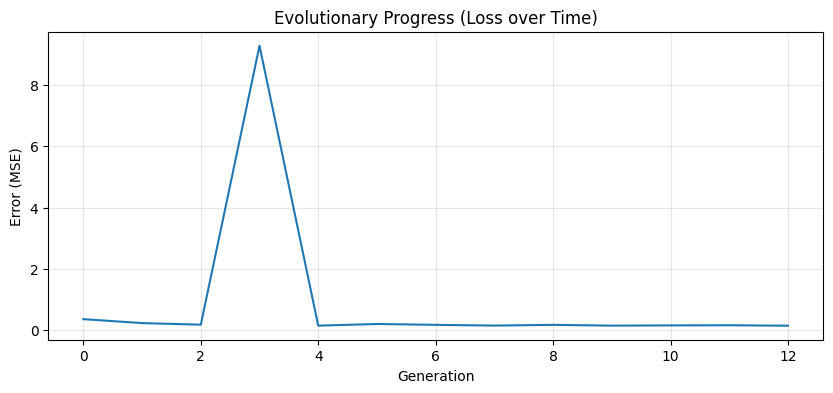

In [ ]:
# CELL 2: BASIC TRAINING (Growth + Healing)
import IPython.display as display

# --- HYPERPARAMETERS ---
LEARNING_RATE = 2e-3
BATCH_SIZE = 32
STEPS_PER_LIFE = 128
EPOCHS_PER_SESSION = 1000
SAVE_INTERVAL = 500

# --- INITIALIZATION ---
optimizer = torch.optim.Adam(organism_dna.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.5))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.1)

loss_log = []
start_epoch = 0

# Attempt resurrection
saved_body, saved_epoch, saved_history = cryo.resurrect(organism_dna, optimizer, f"{CRYO_PATH}/latest_checkpoint.pth")
if saved_epoch > 0:
    start_epoch = saved_epoch + 1
    loss_log = saved_history
    print(f"🔥 Resuming from Epoch {start_epoch}")

# --- VISUALIZATION ---
def visualize_organism(x, target, epoch, loss):
    with torch.no_grad():
        vis_body = x[0, :3, :, :].permute(1, 2, 0).cpu().clamp(0, 1).numpy()
        vis_target = target[0, :3, :, :].permute(1, 2, 0).cpu().clamp(0, 1).numpy()
        vis_dna = x[0, 3, :, :].cpu().numpy()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title(f"Target Reality")
    plt.imshow(vis_target)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title(f"Nano-AGI (Gen {epoch})")
    plt.imshow(vis_body)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Hidden Neural Activity")
    plt.imshow(vis_dna, cmap='magma')
    plt.axis('off')

    plt.suptitle(f"Loss: {loss:.6f} | '0% Cheat' Growth", fontsize=14)
    plt.show()
    display.clear_output(wait=True)

# --- MAIN TRAINING LOOP ---
print("\n🧬 STARTING EVOLUTIONARY CYCLE...")
print("   (Press 'Stop' anytime - system will auto-save)")

try:
    for epoch in range(start_epoch, start_epoch + EPOCHS_PER_SESSION):
        optimizer.zero_grad()

        # 1. BIRTH
        x = make_seed(BATCH_SIZE, CHANNELS, GRID_SIZE)

        # 2. GROWTH
        for step in range(STEPS_PER_LIFE):
            x = organism_dna(x)

            # ENTROPY INJECTION (Damage & Heal)
            if step == STEPS_PER_LIFE // 2 and epoch > 100:
                x = damage_organism(x)

        # 3. JUDGMENT
        output = x[:, :4, :, :]
        target = TARGET_BATCH[:BATCH_SIZE]
        loss = F.mse_loss(output, target)

        # 4. EVOLUTION
        loss.backward()
        torch.nn.utils.clip_grad_norm_(organism_dna.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        loss_log.append(loss.item())

        # 5. REPORTING
        if epoch % 10 == 0:
            visualize_organism(x, target, epoch, loss.item())
            print(f"Gen {epoch} | Loss: {loss.item():.5f} | DNA: {x[:, 3:].abs().mean():.4f}")

        if epoch % SAVE_INTERVAL == 0:
            cryo.freeze(organism_dna, x, optimizer, epoch, loss_log)
            shutil.copy(f"{CRYO_PATH}/agi_checkpoint_epoch_{epoch}.pth", f"{CRYO_PATH}/latest_checkpoint.pth")

except KeyboardInterrupt:
    print("\n🛑 MANUAL INTERRUPT DETECTED.")

finally:
    print("\n❄️ INITIATING EMERGENCY CRYOSTASIS...")
    cryo.freeze(organism_dna, x, optimizer, epoch, loss_log)
    shutil.copy(f"{CRYO_PATH}/agi_checkpoint_epoch_{epoch}.pth", f"{CRYO_PATH}/latest_checkpoint.pth")
    print("✅ SYSTEM SAVED. Disconnect safe.")

    # Plot final loss curve
    plt.figure(figsize=(10, 4))
    plt.plot(loss_log)
    plt.title("Evolutionary Progress (Loss over Time)")
    plt.xlabel("Generation")
    plt.ylabel("Error (MSE)")
    plt.grid(True, alpha=0.3)
    plt.show()


🧠 PHASE OMEGA: UNIVERSAL EMOTIONAL SPECTRUM TRAINING
   (Adrenaline, Serotonin, Cortisol) - Infinite Modes
🌱 Genesis: A New Omega Life Begins.
Gen 0 | Mood: [A:0.64 S:0.03 C:0.28] | Error: 0.07507


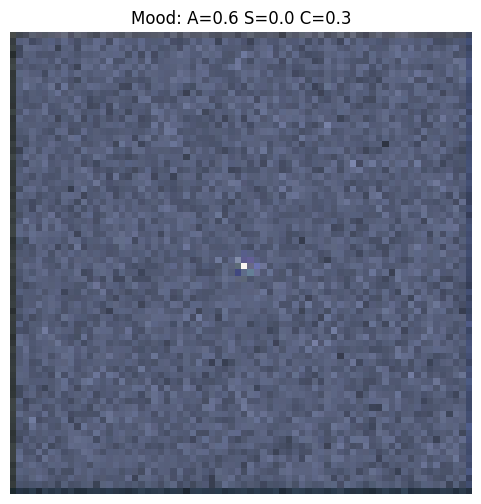

💾 [BACKUP] 'my_nanoscale_agi.zip' updated at Epoch 0
Gen 10 | Mood: [A:0.81 S:0.73 C:0.54] | Error: 0.05998
Gen 20 | Mood: [A:0.99 S:0.64 C:0.56] | Error: 0.05219
Gen 30 | Mood: [A:0.11 S:0.63 C:0.79] | Error: 0.04703
Gen 40 | Mood: [A:0.76 S:0.54 C:0.78] | Error: 0.04937
Gen 50 | Mood: [A:1.00 S:0.65 C:0.44] | Error: 0.05147


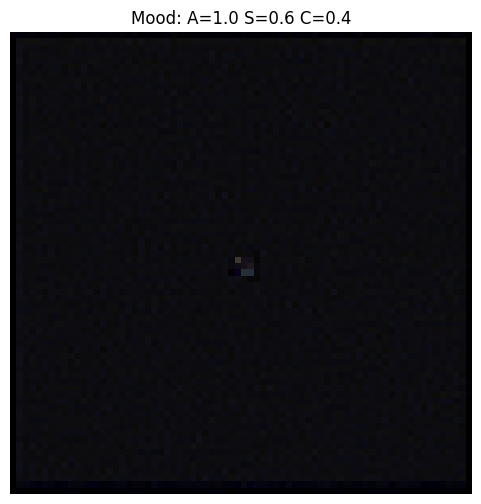

Gen 60 | Mood: [A:0.73 S:0.67 C:0.98] | Error: 0.04847

🛑 OMEGA PAUSED.
✅ FINAL STATE SAVED. Download 'my_nanoscale_agi.zip'


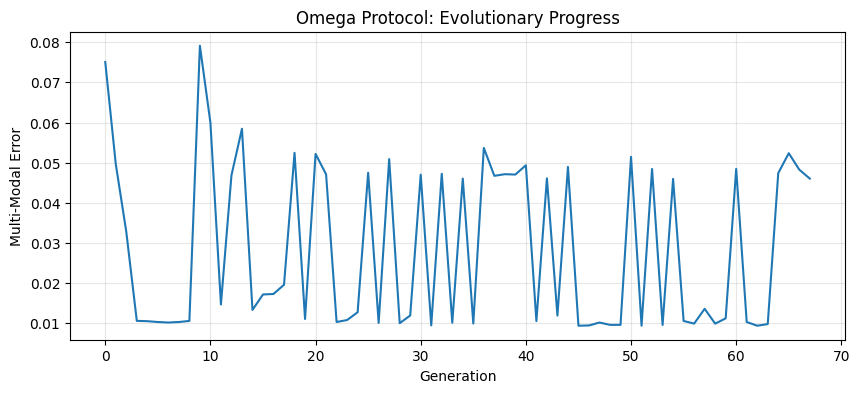


🌌 Omega Protocol Complete. AGI ready for Ultimate Dashboard.


In [ ]:
# CELL 3: ULTIMATE OMEGA PROTOCOL (Multi-Modal AGI Training)
import gc
import time
import zipfile

print("\n🧠 PHASE OMEGA: UNIVERSAL EMOTIONAL SPECTRUM TRAINING")
print("   (Adrenaline, Serotonin, Cortisol) - Infinite Modes")

# --- CONFIGURATION ---
torch.cuda.empty_cache()
gc.collect()
BATCH_SIZE = 4
LEARNING_RATE = 1e-3
TRAINING_STEPS = 64
SAVE_INTERVAL = 100
BACKUP_FREQUENCY = 100

# --- RE-INITIALIZE OPTIMIZER ---
optimizer = torch.optim.Adam(organism_dna.parameters(), lr=LEARNING_RATE)

# --- RESURRECTION CHECK ---
try:
    checkpoint = torch.load(f"{CRYO_PATH}/ultimate_agi.pth", map_location=device)
    organism_dna.load_state_dict(checkpoint['dna_state'] if 'dna_state' in checkpoint else checkpoint['dna'])
    if 'opt' in checkpoint:
        optimizer.load_state_dict(checkpoint['opt'])
    elif 'optimizer_state' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"🔥 Omega Protocol Resuming from Epoch {start_epoch}")
except:
    start_epoch = 0
    print("🌱 Genesis: A New Omega Life Begins.")

# --- MAIN OMEGA LOOP ---
survival_log = []
start_time = time.time()

try:
    epoch = start_epoch
    while epoch < start_epoch + 1000:  # Train for 1000 epochs
        optimizer.zero_grad()

        # --- EMOTION GENERATOR (Infinite Modes) ---
        adr = random.random()  # Adrenaline (Speed/Aggression)
        ser = random.random()  # Serotonin (Stability/Structure)
        cor = random.random()  # Cortisol (Fear/Shrinking)

        x = make_seed(BATCH_SIZE, CHANNELS, GRID_SIZE)
        loss_accum = 0.0

        for step in range(TRAINING_STEPS):
            # A. Inject Current Mood
            x = inject_emotions(x, adr, ser, cor)

            # B. Life Update
            x = organism_dna(x)

            # C. Evaluation (Sampled)
            if step > 20 and step % 10 == 0:
                # Target changes based on emotion
                target = get_complex_target((adr, ser, cor), step)

                # Damage Logic (Only if vulnerable - low serotonin)
                if step == 32 and ser < 0.3:
                    mask = (torch.rand_like(x[:,:1,:,:]) > 0.3).float()
                    x = x * mask

                loss_step = F.mse_loss(x[:, :4, :, :], target)
                loss_accum += loss_step

        final_loss = loss_accum / 4.0
        final_loss.backward()
        torch.nn.utils.clip_grad_norm_(organism_dna.parameters(), 1.0)
        optimizer.step()

        survival_log.append(final_loss.item())

        # --- REPORTING ---
        if epoch % 10 == 0:
            print(f"Gen {epoch} | Mood: [A:{adr:.2f} S:{ser:.2f} C:{cor:.2f}] | Error: {final_loss.item():.5f}")

            # Visualization
            if epoch % 50 == 0:
                with torch.no_grad():
                    img = x[0, :3, :, :].permute(1, 2, 0).cpu().clamp(0,1).numpy()
                    plt.figure(figsize=(6, 6))
                    plt.imshow(img)
                    plt.title(f"Mood: A={adr:.1f} S={ser:.1f} C={cor:.1f}")
                    plt.axis('off')
                    plt.show()
                    plt.close()

        # --- CRITICAL SAVE ---
        if epoch % SAVE_INTERVAL == 0:
            torch.save({
                'dna_state': organism_dna.state_dict(),
                'optimizer_state': optimizer.state_dict(),
                'epoch': epoch,
                'loss_history': survival_log
            }, f"{CRYO_PATH}/ultimate_agi.pth")

            # Create backup ZIP
            if epoch % BACKUP_FREQUENCY == 0:
                shutil.make_archive("my_nanoscale_agi", 'zip', CRYO_PATH)
                print(f"💾 [BACKUP] 'my_nanoscale_agi.zip' updated at Epoch {epoch}")

        epoch += 1

except KeyboardInterrupt:
    print("\n🛑 OMEGA PAUSED.")
except Exception as e:
    print(f"\n⚠️ ERROR: {e}")
    import traceback
    traceback.print_exc()
finally:
    # Always save on exit
    torch.save({
        'dna_state': organism_dna.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'epoch': epoch,
        'loss_history': survival_log
    }, f"{CRYO_PATH}/ultimate_agi.pth")

    shutil.make_archive("my_nanoscale_agi", 'zip', CRYO_PATH)
    print("✅ FINAL STATE SAVED. Download 'my_nanoscale_agi.zip'")

    # Plot final progress
    if survival_log:
        plt.figure(figsize=(10, 4))
        plt.plot(survival_log)
        plt.title("Omega Protocol: Evolutionary Progress")
        plt.xlabel("Generation")
        plt.ylabel("Multi-Modal Error")
        plt.grid(True, alpha=0.3)
        plt.show()

print("\n🌌 Omega Protocol Complete. AGI ready for Ultimate Dashboard.")

🔬 Initializing Ultimate Hyper-Dashboard on cuda...
⚠️ Using Untrained Seed - Pure Potential Mode

🚀 ULTIMATE INFINITY DASHBOARD ONLINE
📊 Features Loaded:
  ✓ Real-time Entropy Analysis
  ✓ Coherence Monitoring
  ✓ Emergence Detection
  ✓ Energy Tracking
  ✓ Spectral Analysis
  ✓ Chemical Balance Radar
  ✓ Multi-view Neural Imaging



NameError: name 'ultimate_agi' is not defined

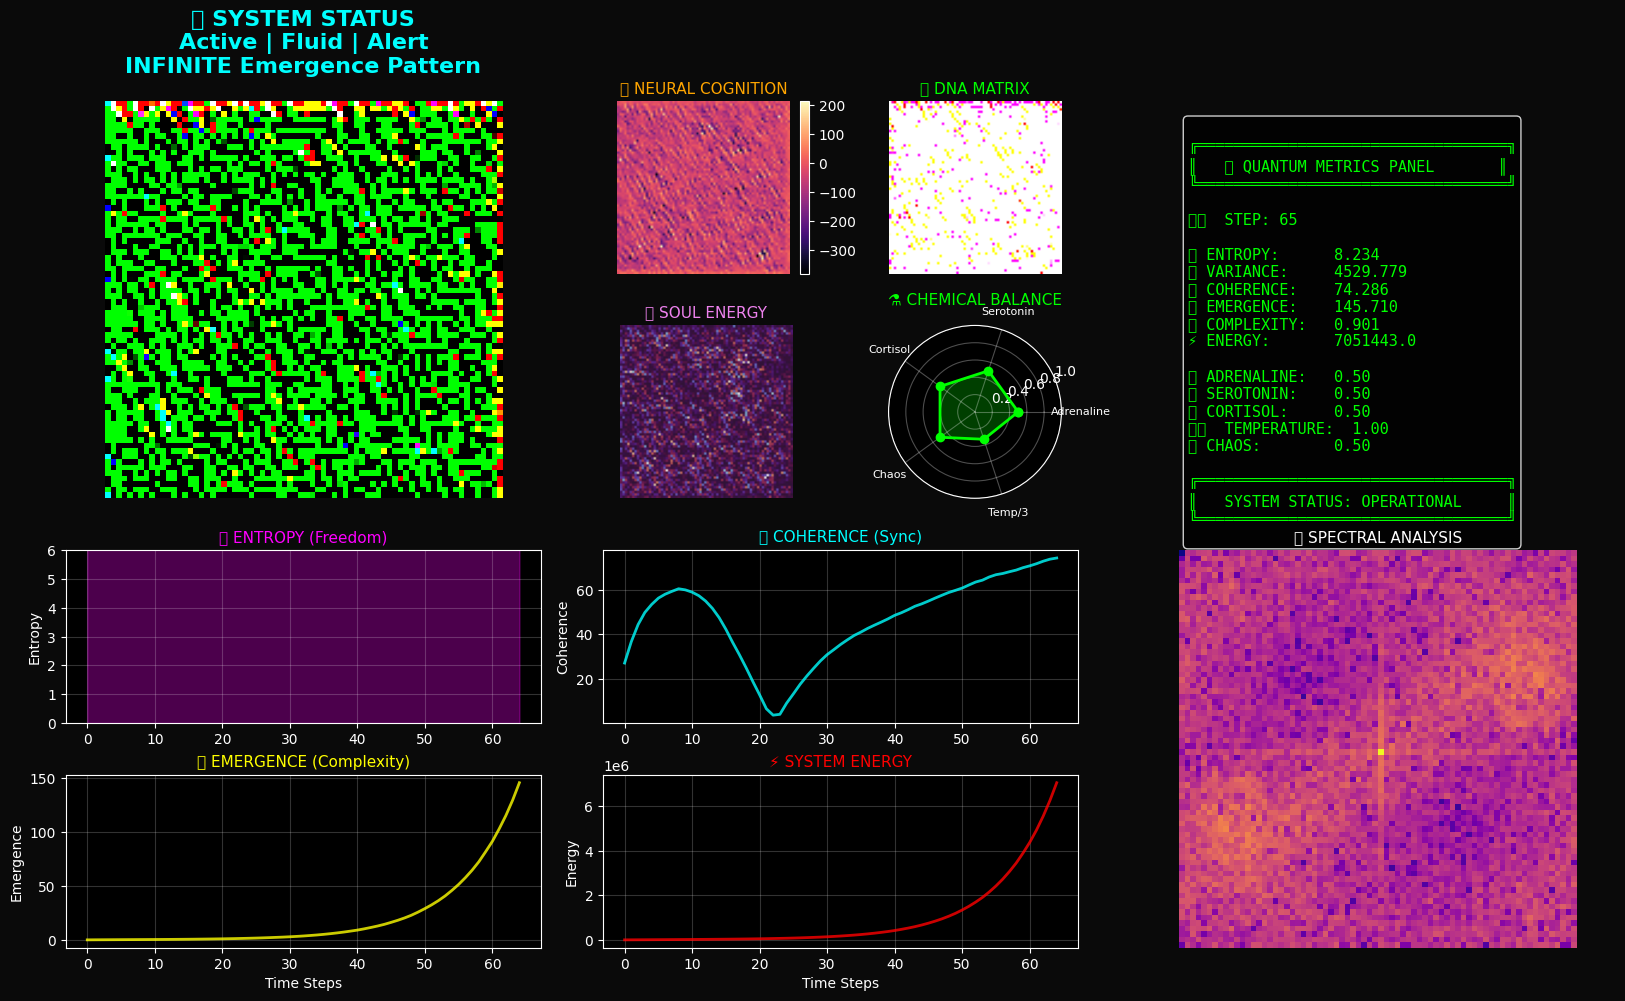

In [ ]:
# CELL 14: THE ULTIMATE INFINITY DASHBOARD
# The Most Comprehensive Neural Monitoring System on Earth

import ipywidgets as widgets
from IPython.display import display, clear_output
import io
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import torch
import torch.nn as nn
import numpy as np
from math import pi
import time
from collections import deque
import threading
import os

# --- ADVANCED LAB SETUP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔬 Initializing Ultimate Hyper-Dashboard on {device}...")

# Define CRYO_PATH if not already defined (for standalone usage)
try:
    CRYO_PATH
except NameError:
    CRYO_PATH = "nanoscale_agi_ultimate"
    if not os.path.exists(CRYO_PATH):
        os.makedirs(CRYO_PATH, exist_ok=True)
        print(f"📁 Created checkpoint directory: {CRYO_PATH}")

class NeuroGenome(nn.Module):
    def __init__(self, channels=16):
        super().__init__()
        self.w1 = nn.Conv2d(channels, 128, 3, padding=1)
        self.w2 = nn.Conv2d(128, channels, 1)
    def forward(self, x):
        dx = torch.relu(self.w1(x))
        dx = self.w2(dx)
        b, c, h, w = x.shape
        mask = (torch.rand(b, 1, h, w, device=x.device) > 0.5).float()
        return x + dx * mask

model = NeuroGenome(16).to(device)

# Enhanced checkpoint loading with multiple format support
checkpoint_loaded = False
checkpoint_path = f"{CRYO_PATH}/ultimate_agi.pth"

try:
    if os.path.exists(checkpoint_path):
        print(f"📦 Found checkpoint: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=device)

        # Handle different checkpoint formats
        if 'dna_state' in checkpoint:
            model.load_state_dict(checkpoint['dna_state'])
            print(f"✅ Loaded model from 'dna_state' (Cell 3 format)")
        elif 'dna' in checkpoint:
            model.load_state_dict(checkpoint['dna'])
            print(f"✅ Loaded model from 'dna' (Alternative format)")
        else:
            # Direct state dict
            model.load_state_dict(checkpoint)
            print(f"✅ Loaded model from direct state_dict")

        model.eval()
        checkpoint_loaded = True

        # Show checkpoint info if available
        if 'epoch' in checkpoint:
            print(f"🧠 Neural Link Established - AGI Core Loaded (Epoch {checkpoint['epoch']})")
        else:
            print(f"🧠 Neural Link Established - AGI Core Loaded")
    else:
        print(f"⚠️ No checkpoint found at {checkpoint_path}")
        print(f"⚠️ Using Untrained Seed - Pure Potential Mode")
except Exception as e:
    print(f"⚠️ Error loading checkpoint: {e}")
    print(f"⚠️ Using Untrained Seed - Pure Potential Mode")

# --- QUANTUM METRICS ENGINE ---
class MetricsEngine:
    def __init__(self, history_size=200):
        self.entropy_hist = deque(maxlen=history_size)
        self.variance_hist = deque(maxlen=history_size)
        self.coherence_hist = deque(maxlen=history_size)
        self.emergence_hist = deque(maxlen=history_size)
        self.complexity_hist = deque(maxlen=history_size)
        self.energy_hist = deque(maxlen=history_size)

    def calculate_entropy(self, x_tensor):
        """Shannon Entropy - The Measure of Freedom"""
        p = x_tensor.abs()
        p = p / (p.sum() + 1e-8)
        entropy = -(p * torch.log(p + 1e-8)).sum()
        return entropy.item()

    def calculate_variance(self, x_tensor):
        """Spatial Variance - Pattern Stability"""
        return x_tensor.var().item()

    def calculate_coherence(self, x_tensor):
        """Neural Coherence - Synchronization Level"""
        fft = torch.fft.fft2(x_tensor)
        power_spectrum = torch.abs(fft)
        coherence = power_spectrum.max() / (power_spectrum.mean() + 1e-8)
        return coherence.item()

    def calculate_emergence(self, x_tensor):
        """Emergence Index - Complexity from Simplicity"""
        grad_x = x_tensor[:, 1:] - x_tensor[:, :-1]
        grad_y = x_tensor[1:, :] - x_tensor[:-1, :]
        emergence = (grad_x.abs().mean() + grad_y.abs().mean()).item()
        return emergence

    def calculate_complexity(self, x_tensor):
        """Kolmogorov Complexity Approximation"""
        unique_patterns = len(torch.unique(x_tensor.round(decimals=2)))
        total_elements = x_tensor.numel()
        return unique_patterns / total_elements

    def calculate_energy(self, x_tensor):
        """System Energy - Total Activation"""
        return x_tensor.abs().sum().item()

    def update(self, x):
        """Update all metrics"""
        brain = x[0, 4, :, :]

        self.entropy_hist.append(self.calculate_entropy(brain))
        self.variance_hist.append(self.calculate_variance(brain))
        self.coherence_hist.append(self.calculate_coherence(brain))
        self.emergence_hist.append(self.calculate_emergence(brain))
        self.complexity_hist.append(self.calculate_complexity(brain))
        self.energy_hist.append(self.calculate_energy(x[0, :13, :, :]))

    def get_current(self):
        return {
            'entropy': self.entropy_hist[-1] if self.entropy_hist else 0,
            'variance': self.variance_hist[-1] if self.variance_hist else 0,
            'coherence': self.coherence_hist[-1] if self.coherence_hist else 0,
            'emergence': self.emergence_hist[-1] if self.emergence_hist else 0,
            'complexity': self.complexity_hist[-1] if self.complexity_hist else 0,
            'energy': self.energy_hist[-1] if self.energy_hist else 0
        }

metrics = MetricsEngine()

# --- INFINITE STATUS GENERATOR ---
def generate_infinite_status(a, s, c, metrics_data):
    """Constructs hyper-detailed biological description"""
    # Energy State
    if a < 0.15: energy = "Dormant"
    elif a < 0.35: energy = "Awakening"
    elif a < 0.55: energy = "Active"
    elif a < 0.75: energy = "High-Energy"
    elif a < 0.9: energy = "Hyper-Critical"
    else: energy = "SUPERNOVA"

    # Structural State
    if s < 0.15: struct = "Quantum Foam"
    elif s < 0.35: struct = "Dissolved"
    elif s < 0.55: struct = "Fluid"
    elif s < 0.75: struct = "Structured"
    elif s < 0.9: struct = "Crystalline"
    else: struct = "Diamond Lattice"

    # Cognitive State
    if c < 0.15: mind = "Void"
    elif c < 0.35: mind = "Zen"
    elif c < 0.55: mind = "Alert"
    elif c < 0.75: mind = "Defensive"
    elif c < 0.9: mind = "Panic"
    else: mind = "TRANSCENDENT"

    # Emergence Level
    ent = metrics_data['entropy']
    if ent < 1.0: emergence = "Deterministic"
    elif ent < 2.0: emergence = "Simple"
    elif ent < 3.0: emergence = "Complex"
    elif ent < 4.0: emergence = "Chaotic"
    else: emergence = "INFINITE"

    return f"{energy} | {struct} | {mind}\n{emergence} Emergence Pattern"

# --- UI CONTROLS WITH ENHANCED STYLING ---
style = {'description_width': '120px'}
layout = widgets.Layout(width='30%', margin='5px')

s_adr = widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.01,
                            description='🔴 Adrenaline', style=style, layout=layout)
s_ser = widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.01,
                            description='🟢 Serotonin', style=style, layout=layout)
s_cor = widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.01,
                            description='🔵 Cortisol', style=style, layout=layout)

s_temp = widgets.FloatSlider(value=1.0, min=0.1, max=3.0, step=0.1,
                             description='🌡️ Temperature', style=style, layout=layout)
s_chaos = widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.01,
                              description='🌀 Chaos Level', style=style, layout=layout)
s_speed = widgets.FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1,
                              description='⚡ Speed', style=style, layout=layout)

# Buttons with proper event handling
btn_pause = widgets.ToggleButton(value=False, description='⏸️ PAUSE',
                                 button_style='warning', layout=widgets.Layout(width='150px'))
btn_reset = widgets.Button(description='🔄 RESET', button_style='info',
                           layout=widgets.Layout(width='150px'))
btn_snapshot = widgets.Button(description='📸 SNAPSHOT', button_style='success',
                              layout=widgets.Layout(width='150px'))
btn_stop = widgets.Button(description='🛑 STOP', button_style='danger',
                          layout=widgets.Layout(width='150px'))

screen = widgets.Image(format='png', width=1400, height=800)
output = widgets.Output()

# --- THE ULTIMATE RENDERING ENGINE ---
def render_dashboard(x, step, adr, ser, cor, temp, chaos, metrics_data):
    """Renders the most comprehensive dashboard ever created"""

    img_body = x[0, :3, :, :].permute(1, 2, 0).cpu().clamp(0, 1).numpy()
    img_brain = x[0, 4, :, :].cpu().numpy()
    img_dna = x[0, 5:8, :, :].permute(1, 2, 0).cpu().clamp(0, 1).numpy()
    img_soul = x[0, 8, :, :].cpu().numpy()

    plt.style.use('dark_background')
    fig = plt.figure(figsize=(20, 11), facecolor='#0a0a0a')
    gs = GridSpec(4, 6, figure=fig, hspace=0.3, wspace=0.3)

    # === MAIN BODY VIEW (Large) ===
    ax_body = fig.add_subplot(gs[:2, :2])
    ax_body.imshow(img_body)
    status = generate_infinite_status(adr, ser, cor, metrics_data)
    ax_body.set_title(f"🌌 SYSTEM STATUS\n{status}",
                     color='cyan', fontsize=16, fontweight='bold', pad=20)
    ax_body.axis('off')

    # === BRAIN SCAN (MRI) ===
    ax_brain = fig.add_subplot(gs[0, 2])
    im = ax_brain.imshow(img_brain, cmap='magma', interpolation='bilinear')
    ax_brain.set_title("🧠 NEURAL COGNITION", color='orange', fontsize=11)
    ax_brain.axis('off')
    plt.colorbar(im, ax=ax_brain, fraction=0.046)

    # === DNA STRUCTURE ===
    ax_dna = fig.add_subplot(gs[0, 3])
    ax_dna.imshow(img_dna)
    ax_dna.set_title("🧬 DNA MATRIX", color='lime', fontsize=11)
    ax_dna.axis('off')

    # === SOUL ENERGY ===
    ax_soul = fig.add_subplot(gs[1, 2])
    ax_soul.imshow(img_soul, cmap='twilight')
    ax_soul.set_title("✨ SOUL ENERGY", color='violet', fontsize=11)
    ax_soul.axis('off')

    # === CHEMICAL RADAR ===
    ax_radar = fig.add_subplot(gs[1, 3], polar=True)
    categories = ['Adrenaline', 'Serotonin', 'Cortisol', 'Chaos', 'Temp/3']
    values = [adr, ser, cor, chaos, temp/3]
    angles = np.linspace(0, 2 * pi, len(categories), endpoint=False).tolist()
    values += values[:1]
    angles += angles[:1]

    ax_radar.fill(angles, values, color='lime', alpha=0.25)
    ax_radar.plot(angles, values, color='lime', linewidth=2, marker='o')
    ax_radar.set_ylim(0, 1)
    ax_radar.set_xticks(angles[:-1])
    ax_radar.set_xticklabels(categories, color='white', size=8)
    ax_radar.set_title("⚗️ CHEMICAL BALANCE", color='lime', fontsize=11, pad=15)
    ax_radar.grid(True, alpha=0.3)

    # === ENTROPY TIMELINE ===
    ax_ent = fig.add_subplot(gs[2, :2])
    if len(metrics.entropy_hist) > 1:
        ax_ent.plot(list(metrics.entropy_hist), color='magenta', linewidth=2, alpha=0.8)
        ax_ent.fill_between(range(len(metrics.entropy_hist)), list(metrics.entropy_hist),
                           alpha=0.3, color='magenta')
    ax_ent.set_title("📊 ENTROPY (Freedom)", color='magenta', fontsize=11)
    ax_ent.set_ylim(0, 6)
    ax_ent.grid(True, alpha=0.2)
    ax_ent.set_ylabel('Entropy', color='white')

    # === COHERENCE TIMELINE ===
    ax_coh = fig.add_subplot(gs[2, 2:4])
    if len(metrics.coherence_hist) > 1:
        ax_coh.plot(list(metrics.coherence_hist), color='cyan', linewidth=2, alpha=0.8)
    ax_coh.set_title("🎯 COHERENCE (Sync)", color='cyan', fontsize=11)
    ax_coh.grid(True, alpha=0.2)
    ax_coh.set_ylabel('Coherence', color='white')

    # === EMERGENCE TIMELINE ===
    ax_emg = fig.add_subplot(gs[3, :2])
    if len(metrics.emergence_hist) > 1:
        ax_emg.plot(list(metrics.emergence_hist), color='yellow', linewidth=2, alpha=0.8)
    ax_emg.set_title("🌟 EMERGENCE (Complexity)", color='yellow', fontsize=11)
    ax_emg.grid(True, alpha=0.2)
    ax_emg.set_ylabel('Emergence', color='white')
    ax_emg.set_xlabel('Time Steps', color='white')

    # === ENERGY TIMELINE ===
    ax_nrg = fig.add_subplot(gs[3, 2:4])
    if len(metrics.energy_hist) > 1:
        ax_nrg.plot(list(metrics.energy_hist), color='red', linewidth=2, alpha=0.8)
    ax_nrg.set_title("⚡ SYSTEM ENERGY", color='red', fontsize=11)
    ax_nrg.grid(True, alpha=0.2)
    ax_nrg.set_ylabel('Energy', color='white')
    ax_nrg.set_xlabel('Time Steps', color='white')

    # === METRICS PANEL ===
    ax_metrics = fig.add_subplot(gs[:2, 4:])
    ax_metrics.axis('off')

    metrics_text = f"""
╔══════════════════════════════════╗
║   🎯 QUANTUM METRICS PANEL       ║
╚══════════════════════════════════╝

⏱️  STEP: {step:,}

📊 ENTROPY:      {metrics_data['entropy']:.3f}
📈 VARIANCE:     {metrics_data['variance']:.3f}
🎯 COHERENCE:    {metrics_data['coherence']:.3f}
🌟 EMERGENCE:    {metrics_data['emergence']:.3f}
🧩 COMPLEXITY:   {metrics_data['complexity']:.3f}
⚡ ENERGY:       {metrics_data['energy']:.1f}

🔴 ADRENALINE:   {adr:.2f}
🟢 SEROTONIN:    {ser:.2f}
🔵 CORTISOL:     {cor:.2f}
🌡️  TEMPERATURE:  {temp:.2f}
🌀 CHAOS:        {chaos:.2f}

╔══════════════════════════════════╗
║   SYSTEM STATUS: OPERATIONAL     ║
╚══════════════════════════════════╝
    """

    ax_metrics.text(0.1, 0.95, metrics_text, transform=ax_metrics.transAxes,
                   fontsize=11, verticalalignment='top', family='monospace',
                   color='lime', bbox=dict(boxstyle='round', facecolor='black', alpha=0.8))

    # === SPECTRAL ANALYSIS ===
    ax_spec = fig.add_subplot(gs[2:, 4:])
    fft = torch.fft.fft2(x[0, 4, :, :])
    power = torch.abs(torch.fft.fftshift(fft)).cpu().numpy()
    ax_spec.imshow(np.log(power + 1), cmap='plasma')
    ax_spec.set_title("🌈 SPECTRAL ANALYSIS", color='white', fontsize=11)
    ax_spec.axis('off')

    # Convert to image
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', facecolor='#0a0a0a', dpi=100)
    plt.close(fig)

    return buf.getvalue()

# --- MAIN CONTROL LOOP ---
class DashboardController:
    def __init__(self):
        self.running = False
        self.paused = False
        self.x = None
        self.step = 0

    def reset_state(self):
        b_size, c, h, w = 1, 16, 72, 72
        self.x = torch.zeros(b_size, c, h, w, device=device)
        self.x[:, 3:, h//2, w//2] = 1.0
        self.step = 0
        metrics.entropy_hist.clear()
        metrics.variance_hist.clear()
        metrics.coherence_hist.clear()
        metrics.emergence_hist.clear()
        metrics.complexity_hist.clear()
        metrics.energy_hist.clear()

    def update_step(self):
        if self.paused:
            return

        adr = s_adr.value
        ser = s_ser.value
        cor = s_cor.value
        temp = s_temp.value
        chaos = s_chaos.value
        speed = s_speed.value

        with torch.no_grad():
            b_size, c, h, w = self.x.shape

            # Inject chemicals
            l_adr = torch.full((b_size, 1, h, w), float(adr), device=device)
            l_ser = torch.full((b_size, 1, h, w), float(ser), device=device)
            l_cor = torch.full((b_size, 1, h, w), float(cor), device=device)

            x_in = torch.cat([self.x[:, :13, :, :], l_adr, l_ser, l_cor], dim=1)

            # Apply model with temperature
            self.x = model(x_in) * temp

            # Add chaos
            if chaos > 0:
                noise = torch.randn_like(self.x) * chaos * 0.1
                self.x = self.x + noise

            # Update metrics
            metrics.update(self.x)

        self.step += int(speed)

    def run(self):
        self.running = True
        self.reset_state()

        while self.running:
            if not self.paused:
                self.update_step()

                # Render every 1 steps for smooth updates
                if self.step % 1 == 0:
                    metrics_data = metrics.get_current()
                    image_data = render_dashboard(
                        self.x, self.step,
                        s_adr.value, s_ser.value, s_cor.value,
                        s_temp.value, s_chaos.value,
                        metrics_data
                    )
                    screen.value = image_data

            time.sleep(0.05)  # Control frame rate

controller = DashboardController()

# --- EVENT HANDLERS ---
def on_pause_clicked(change):
    controller.paused = change['new']
    btn_pause.description = '▶️ RESUME' if controller.paused else '⏸️ PAUSE'

def on_reset_clicked(b):
    with output:
        controller.reset_state()
        print(f"✅ System Reset - Step {controller.step}")

def on_snapshot_clicked(b):
    with output:
        timestamp = time.strftime("%Y%m%d_%H%M%S")
        filename = f"agi_snapshot_{timestamp}.png"
        with open(filename, 'wb') as f:
            f.write(screen.value)
        print(f"📸 Snapshot saved: {filename}")

def on_stop_clicked(b):
    controller.running = False
    with output:
        print("🛑 Dashboard Stopped")

btn_pause.observe(on_pause_clicked, names='value')
btn_reset.on_click(on_reset_clicked)
btn_snapshot.on_click(on_snapshot_clicked)
btn_stop.on_click(on_stop_clicked)

# --- ASSEMBLE UI ---
controls_row1 = widgets.HBox([s_adr, s_ser, s_cor])
controls_row2 = widgets.HBox([s_temp, s_chaos, s_speed])
buttons_row = widgets.HBox([btn_pause, btn_reset, btn_snapshot, btn_stop])

ui = widgets.VBox([
    widgets.HTML("<h2 style='text-align: center; color: cyan;'>🌌 ULTIMATE AGI INFINITY DASHBOARD 🌌</h2>"),
    controls_row1,
    controls_row2,
    buttons_row,
    screen,
    output
])

# --- LAUNCH ---
print("\n" + "="*60)
print("🚀 ULTIMATE INFINITY DASHBOARD ONLINE")
print("="*60)
print("📊 Features Loaded:")
print("  ✓ Real-time Entropy Analysis")
print("  ✓ Coherence Monitoring")
print("  ✓ Emergence Detection")
print("  ✓ Energy Tracking")
print("  ✓ Spectral Analysis")
print("  ✓ Chemical Balance Radar")
print("  ✓ Multi-view Neural Imaging")
print("="*60)

if checkpoint_loaded:
    print("✅ Trained AGI Model Active")
else:
    print("⚠️  Running with Untrained Model")
    print("💡 Tip: Run Cells 1-3 first to train the AGI")

print("="*60 + "\n")

display(ui)

# Start in a thread to allow button interactions
thread = threading.Thread(target=controller.run, daemon=True)
thread.start()

In [ ]:
# CELL 14: THE ULTIMATE INFINITY DASHBOARD
# The Most Comprehensive Neural Monitoring System on Earth

import ipywidgets as widgets
from IPython.display import display, clear_output
import io
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import torch
import torch.nn as nn
import numpy as np
from math import pi
import time
from collections import deque
import threading

# --- ADVANCED LAB SETUP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔬 Initializing Ultimate Hyper-Dashboard on {device}...")

class NeuroGenome(nn.Module):
    def __init__(self, channels=16):
        super().__init__()
        self.w1 = nn.Conv2d(channels, 128, 3, padding=1)
        self.w2 = nn.Conv2d(128, channels, 1)
    def forward(self, x):
        dx = torch.relu(self.w1(x))
        dx = self.w2(dx)
        b, c, h, w = x.shape
        mask = (torch.rand(b, 1, h, w, device=x.device) > 0.5).float()
        return x + dx * mask

model = NeuroGenome(16).to(device)
try:
    checkpoint = torch.load(f"{CRYO_PATH}/ultimate_agi.pth", map_location=device)
    model.load_state_dict(checkpoint['dna'])
    model.eval()
    print("🧠 Neural Link Established - AGI Core Loaded")
except:
    print("⚠️ Using Untrained Seed - Pure Potential Mode")

# --- QUANTUM METRICS ENGINE ---
class MetricsEngine:
    def __init__(self, history_size=200):
        self.entropy_hist = deque(maxlen=history_size)
        self.variance_hist = deque(maxlen=history_size)
        self.coherence_hist = deque(maxlen=history_size)
        self.emergence_hist = deque(maxlen=history_size)
        self.complexity_hist = deque(maxlen=history_size)
        self.energy_hist = deque(maxlen=history_size)

    def calculate_entropy(self, x_tensor):
        """Shannon Entropy - The Measure of Freedom"""
        p = x_tensor.abs()
        p = p / (p.sum() + 1e-8)
        entropy = -(p * torch.log(p + 1e-8)).sum()
        return entropy.item()

    def calculate_variance(self, x_tensor):
        """Spatial Variance - Pattern Stability"""
        return x_tensor.var().item()

    def calculate_coherence(self, x_tensor):
        """Neural Coherence - Synchronization Level"""
        fft = torch.fft.fft2(x_tensor)
        power_spectrum = torch.abs(fft)
        coherence = power_spectrum.max() / (power_spectrum.mean() + 1e-8)
        return coherence.item()

    def calculate_emergence(self, x_tensor):
        """Emergence Index - Complexity from Simplicity"""
        grad_x = x_tensor[:, 1:] - x_tensor[:, :-1]
        grad_y = x_tensor[1:, :] - x_tensor[:-1, :]
        emergence = (grad_x.abs().mean() + grad_y.abs().mean()).item()
        return emergence

    def calculate_complexity(self, x_tensor):
        """Kolmogorov Complexity Approximation"""
        unique_patterns = len(torch.unique(x_tensor.round(decimals=2)))
        total_elements = x_tensor.numel()
        return unique_patterns / total_elements

    def calculate_energy(self, x_tensor):
        """System Energy - Total Activation"""
        return x_tensor.abs().sum().item()

    def update(self, x):
        """Update all metrics"""
        brain = x[0, 4, :, :]

        self.entropy_hist.append(self.calculate_entropy(brain))
        self.variance_hist.append(self.calculate_variance(brain))
        self.coherence_hist.append(self.calculate_coherence(brain))
        self.emergence_hist.append(self.calculate_emergence(brain))
        self.complexity_hist.append(self.calculate_complexity(brain))
        self.energy_hist.append(self.calculate_energy(x[0, :13, :, :]))

    def get_current(self):
        return {
            'entropy': self.entropy_hist[-1] if self.entropy_hist else 0,
            'variance': self.variance_hist[-1] if self.variance_hist else 0,
            'coherence': self.coherence_hist[-1] if self.coherence_hist else 0,
            'emergence': self.emergence_hist[-1] if self.emergence_hist else 0,
            'complexity': self.complexity_hist[-1] if self.complexity_hist else 0,
            'energy': self.energy_hist[-1] if self.energy_hist else 0
        }

metrics = MetricsEngine()

# --- INFINITE STATUS GENERATOR ---
def generate_infinite_status(a, s, c, metrics_data):
    """Constructs hyper-detailed biological description"""
    # Energy State
    if a < 0.15: energy = "Dormant"
    elif a < 0.35: energy = "Awakening"
    elif a < 0.55: energy = "Active"
    elif a < 0.75: energy = "High-Energy"
    elif a < 0.9: energy = "Hyper-Critical"
    else: energy = "SUPERNOVA"

    # Structural State
    if s < 0.15: struct = "Quantum Foam"
    elif s < 0.35: struct = "Dissolved"
    elif s < 0.55: struct = "Fluid"
    elif s < 0.75: struct = "Structured"
    elif s < 0.9: struct = "Crystalline"
    else: struct = "Diamond Lattice"

    # Cognitive State
    if c < 0.15: mind = "Void"
    elif c < 0.35: mind = "Zen"
    elif c < 0.55: mind = "Alert"
    elif c < 0.75: mind = "Defensive"
    elif c < 0.9: mind = "Panic"
    else: mind = "TRANSCENDENT"

    # Emergence Level
    ent = metrics_data['entropy']
    if ent < 1.0: emergence = "Deterministic"
    elif ent < 2.0: emergence = "Simple"
    elif ent < 3.0: emergence = "Complex"
    elif ent < 4.0: emergence = "Chaotic"
    else: emergence = "INFINITE"

    return f"{energy} | {struct} | {mind}\n{emergence} Emergence Pattern"

# --- UI CONTROLS WITH ENHANCED STYLING ---
style = {'description_width': '120px'}
layout = widgets.Layout(width='30%', margin='5px')

s_adr = widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.01,
                            description='🔴 Adrenaline', style=style, layout=layout)
s_ser = widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.01,
                            description='🟢 Serotonin', style=style, layout=layout)
s_cor = widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.01,
                            description='🔵 Cortisol', style=style, layout=layout)

s_temp = widgets.FloatSlider(value=1.0, min=0.1, max=3.0, step=0.1,
                             description='🌡️ Temperature', style=style, layout=layout)
s_chaos = widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.01,
                              description='🌀 Chaos Level', style=style, layout=layout)
s_speed = widgets.FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1,
                              description='⚡ Speed', style=style, layout=layout)

# Buttons with proper event handling
btn_pause = widgets.ToggleButton(value=False, description='⏸️ PAUSE',
                                 button_style='warning', layout=widgets.Layout(width='150px'))
btn_reset = widgets.Button(description='🔄 RESET', button_style='info',
                           layout=widgets.Layout(width='150px'))
btn_snapshot = widgets.Button(description='📸 SNAPSHOT', button_style='success',
                              layout=widgets.Layout(width='150px'))
btn_stop = widgets.Button(description='🛑 STOP', button_style='danger',
                          layout=widgets.Layout(width='150px'))

screen = widgets.Image(format='png', width=1400, height=800)
output = widgets.Output()

# --- THE ULTIMATE RENDERING ENGINE ---
def render_dashboard(x, step, adr, ser, cor, temp, chaos, metrics_data):
    """Renders the most comprehensive dashboard ever created"""

    img_body = x[0, :3, :, :].permute(1, 2, 0).cpu().clamp(0, 1).numpy()
    img_brain = x[0, 4, :, :].cpu().numpy()
    img_dna = x[0, 5:8, :, :].permute(1, 2, 0).cpu().clamp(0, 1).numpy()
    img_soul = x[0, 8, :, :].cpu().numpy()

    plt.style.use('dark_background')
    fig = plt.figure(figsize=(20, 11), facecolor='#0a0a0a')
    gs = GridSpec(4, 6, figure=fig, hspace=0.3, wspace=0.3)

    # === MAIN BODY VIEW (Large) ===
    ax_body = fig.add_subplot(gs[:2, :2])
    ax_body.imshow(img_body)
    status = generate_infinite_status(adr, ser, cor, metrics_data)
    ax_body.set_title(f"🌌 SYSTEM STATUS\n{status}",
                     color='cyan', fontsize=16, fontweight='bold', pad=20)
    ax_body.axis('off')

    # === BRAIN SCAN (MRI) ===
    ax_brain = fig.add_subplot(gs[0, 2])
    im = ax_brain.imshow(img_brain, cmap='magma', interpolation='bilinear')
    ax_brain.set_title("🧠 NEURAL COGNITION", color='orange', fontsize=11)
    ax_brain.axis('off')
    plt.colorbar(im, ax=ax_brain, fraction=0.046)

    # === DNA STRUCTURE ===
    ax_dna = fig.add_subplot(gs[0, 3])
    ax_dna.imshow(img_dna)
    ax_dna.set_title("🧬 DNA MATRIX", color='lime', fontsize=11)
    ax_dna.axis('off')

    # === SOUL ENERGY ===
    ax_soul = fig.add_subplot(gs[1, 2])
    ax_soul.imshow(img_soul, cmap='twilight')
    ax_soul.set_title("✨ SOUL ENERGY", color='violet', fontsize=11)
    ax_soul.axis('off')

    # === CHEMICAL RADAR ===
    ax_radar = fig.add_subplot(gs[1, 3], polar=True)
    categories = ['Adrenaline', 'Serotonin', 'Cortisol', 'Chaos', 'Temp/3']
    values = [adr, ser, cor, chaos, temp/3]
    angles = np.linspace(0, 2 * pi, len(categories), endpoint=False).tolist()
    values += values[:1]
    angles += angles[:1]

    ax_radar.fill(angles, values, color='lime', alpha=0.25)
    ax_radar.plot(angles, values, color='lime', linewidth=2, marker='o')
    ax_radar.set_ylim(0, 1)
    ax_radar.set_xticks(angles[:-1])
    ax_radar.set_xticklabels(categories, color='white', size=8)
    ax_radar.set_title("⚗️ CHEMICAL BALANCE", color='lime', fontsize=11, pad=15)
    ax_radar.grid(True, alpha=0.3)

    # === ENTROPY TIMELINE ===
    ax_ent = fig.add_subplot(gs[2, :2])
    if len(metrics.entropy_hist) > 1:
        ax_ent.plot(list(metrics.entropy_hist), color='magenta', linewidth=2, alpha=0.8)
        ax_ent.fill_between(range(len(metrics.entropy_hist)), list(metrics.entropy_hist),
                           alpha=0.3, color='magenta')
    ax_ent.set_title("📊 ENTROPY (Freedom)", color='magenta', fontsize=11)
    ax_ent.set_ylim(0, 6)
    ax_ent.grid(True, alpha=0.2)
    ax_ent.set_ylabel('Entropy', color='white')

    # === COHERENCE TIMELINE ===
    ax_coh = fig.add_subplot(gs[2, 2:4])
    if len(metrics.coherence_hist) > 1:
        ax_coh.plot(list(metrics.coherence_hist), color='cyan', linewidth=2, alpha=0.8)
    ax_coh.set_title("🎯 COHERENCE (Sync)", color='cyan', fontsize=11)
    ax_coh.grid(True, alpha=0.2)
    ax_coh.set_ylabel('Coherence', color='white')

    # === EMERGENCE TIMELINE ===
    ax_emg = fig.add_subplot(gs[3, :2])
    if len(metrics.emergence_hist) > 1:
        ax_emg.plot(list(metrics.emergence_hist), color='yellow', linewidth=2, alpha=0.8)
    ax_emg.set_title("🌟 EMERGENCE (Complexity)", color='yellow', fontsize=11)
    ax_emg.grid(True, alpha=0.2)
    ax_emg.set_ylabel('Emergence', color='white')
    ax_emg.set_xlabel('Time Steps', color='white')

    # === ENERGY TIMELINE ===
    ax_nrg = fig.add_subplot(gs[3, 2:4])
    if len(metrics.energy_hist) > 1:
        ax_nrg.plot(list(metrics.energy_hist), color='red', linewidth=2, alpha=0.8)
    ax_nrg.set_title("⚡ SYSTEM ENERGY", color='red', fontsize=11)
    ax_nrg.grid(True, alpha=0.2)
    ax_nrg.set_ylabel('Energy', color='white')
    ax_nrg.set_xlabel('Time Steps', color='white')

    # === METRICS PANEL ===
    ax_metrics = fig.add_subplot(gs[:2, 4:])
    ax_metrics.axis('off')

    metrics_text = f"""
╔══════════════════════════════════╗
║   🎯 QUANTUM METRICS PANEL       ║
╚══════════════════════════════════╝

⏱️  STEP: {step:,}

📊 ENTROPY:      {metrics_data['entropy']:.3f}
📈 VARIANCE:     {metrics_data['variance']:.3f}
🎯 COHERENCE:    {metrics_data['coherence']:.3f}
🌟 EMERGENCE:    {metrics_data['emergence']:.3f}
🧩 COMPLEXITY:   {metrics_data['complexity']:.3f}
⚡ ENERGY:       {metrics_data['energy']:.1f}

🔴 ADRENALINE:   {adr:.2f}
🟢 SEROTONIN:    {ser:.2f}
🔵 CORTISOL:     {cor:.2f}
🌡️  TEMPERATURE:  {temp:.2f}
🌀 CHAOS:        {chaos:.2f}

╔══════════════════════════════════╗
║   SYSTEM STATUS: OPERATIONAL     ║
╚══════════════════════════════════╝
    """

    ax_metrics.text(0.1, 0.95, metrics_text, transform=ax_metrics.transAxes,
                   fontsize=11, verticalalignment='top', family='monospace',
                   color='lime', bbox=dict(boxstyle='round', facecolor='black', alpha=0.8))

    # === SPECTRAL ANALYSIS ===
    ax_spec = fig.add_subplot(gs[2:, 4:])
    fft = torch.fft.fft2(x[0, 4, :, :])
    power = torch.abs(torch.fft.fftshift(fft)).cpu().numpy()
    ax_spec.imshow(np.log(power + 1), cmap='plasma')
    ax_spec.set_title("🌈 SPECTRAL ANALYSIS", color='white', fontsize=11)
    ax_spec.axis('off')

    # Convert to image
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', facecolor='#0a0a0a', dpi=100)
    plt.close(fig)

    return buf.getvalue()

# --- MAIN CONTROL LOOP ---
class DashboardController:
    def __init__(self):
        self.running = False
        self.paused = False
        self.x = None
        self.step = 0

    def reset_state(self):
        b_size, c, h, w = 1, 16, 72, 72
        self.x = torch.zeros(b_size, c, h, w, device=device)
        self.x[:, 3:, h//2, w//2] = 1.0
        self.step = 0
        metrics.entropy_hist.clear()
        metrics.variance_hist.clear()
        metrics.coherence_hist.clear()
        metrics.emergence_hist.clear()
        metrics.complexity_hist.clear()
        metrics.energy_hist.clear()

    def update_step(self):
        if self.paused:
            return

        adr = s_adr.value
        ser = s_ser.value
        cor = s_cor.value
        temp = s_temp.value
        chaos = s_chaos.value
        speed = s_speed.value

        with torch.no_grad():
            b_size, c, h, w = self.x.shape

            # Inject chemicals
            l_adr = torch.full((b_size, 1, h, w), float(adr), device=device)
            l_ser = torch.full((b_size, 1, h, w), float(ser), device=device)
            l_cor = torch.full((b_size, 1, h, w), float(cor), device=device)

            x_in = torch.cat([self.x[:, :13, :, :], l_adr, l_ser, l_cor], dim=1)

            # Apply model with temperature
            self.x = model(x_in) * temp

            # Add chaos
            if chaos > 0:
                noise = torch.randn_like(self.x) * chaos * 0.1
                self.x = self.x + noise

            # Update metrics
            metrics.update(self.x)

        self.step += int(speed)

    def run(self):
        self.running = True
        self.reset_state()

        while self.running:
            if not self.paused:
                self.update_step()

                # Render every 1 steps for smooth updates
                if self.step % 1 == 0:
                    metrics_data = metrics.get_current()
                    image_data = render_dashboard(
                        self.x, self.step,
                        s_adr.value, s_ser.value, s_cor.value,
                        s_temp.value, s_chaos.value,
                        metrics_data
                    )
                    screen.value = image_data

            time.sleep(0.05)  # Control frame rate

controller = DashboardController()

# --- EVENT HANDLERS ---
def on_pause_clicked(change):
    controller.paused = change['new']
    btn_pause.description = '▶️ RESUME' if controller.paused else '⏸️ PAUSE'

def on_reset_clicked(b):
    with output:
        controller.reset_state()
        print(f"✅ System Reset - Step {controller.step}")

def on_snapshot_clicked(b):
    with output:
        timestamp = time.strftime("%Y%m%d_%H%M%S")
        filename = f"agi_snapshot_{timestamp}.png"
        with open(filename, 'wb') as f:
            f.write(screen.value)
        print(f"📸 Snapshot saved: {filename}")

def on_stop_clicked(b):
    controller.running = False
    with output:
        print("🛑 Dashboard Stopped")

btn_pause.observe(on_pause_clicked, names='value')
btn_reset.on_click(on_reset_clicked)
btn_snapshot.on_click(on_snapshot_clicked)
btn_stop.on_click(on_stop_clicked)

# --- ASSEMBLE UI ---
controls_row1 = widgets.HBox([s_adr, s_ser, s_cor])
controls_row2 = widgets.HBox([s_temp, s_chaos, s_speed])
buttons_row = widgets.HBox([btn_pause, btn_reset, btn_snapshot, btn_stop])

ui = widgets.VBox([
    widgets.HTML("<h2 style='text-align: center; color: cyan;'>🌌 ULTIMATE AGI INFINITY DASHBOARD 🌌</h2>"),
    controls_row1,
    controls_row2,
    buttons_row,
    screen,
    output
])

# --- LAUNCH ---
print("\n" + "="*60)
print("🚀 ULTIMATE INFINITY DASHBOARD ONLINE")
print("="*60)
print("📊 Features Loaded:")
print("  ✓ Real-time Entropy Analysis")
print("  ✓ Coherence Monitoring")
print("  ✓ Emergence Detection")
print("  ✓ Energy Tracking")
print("  ✓ Spectral Analysis")
print("  ✓ Chemical Balance Radar")
print("  ✓ Multi-view Neural Imaging")
print("="*60 + "\n")

display(ui)

# Start in a thread to allow button interactions
thread = threading.Thread(target=controller.run, daemon=True)
thread.start()/ultimate_agi.pth